## Reconstruction of Complex Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import random
import operator as op
from functools import reduce
from tqdm import tqdm
import copy

### Partitioning

In [2]:
def all_part_maker(N, size_list, color_list):
    return([partitioner(size_list, color_list) for i in range(N)])

def ncr(n, r):  #n choose r
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def index_2d(myList, v):
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))
        
def l_ij(alpha,beta, A_T,part):       #number of links between group i and j
    link_num = 0
    for a in part[alpha]:
        for b in part[beta]:
            if A_T[a, b] == 1:
                link_num += 1
    return(link_num)
                
    
def r_ij(alpha,beta, part):       #maximum possible number of links between group i and j
    return(len(part[alpha]) * len(part[beta]))

def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
    big_sum= 0
    Z=0
    for part in all_part:  

        sigma_i = index_2d(part, i)[0]
        sigma_j = index_2d(part, j)[0]
        l = l_ij(sigma_i , sigma_j , A_T, part)
        r = r_ij(sigma_i , sigma_j , part)
        paran = ((l + 1)/(r+2))

        gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]     
        pair_list=[]
        for x in gooz_list:
            if x not in pair_list: pair_list.append(x)
        H_P = 0
        for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, A_T, part)
            r = r_ij(alpha, beta, part)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
        Z += np.exp(-H_P)
        big_sum += paran* np.exp(-H_P)
        R_ij = big_sum/Z 
    # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
    return(round(R_ij,5))

def H(P):
    pair_list=[]
    H_P=0
    for i in range(len(P)):
        for j in range(len(P)):
            if i<j:
                pair_list.append([i,j])
    for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, A_T, P)
            r = r_ij(alpha, beta, P)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
    return(H_P)


def Metro(T,ens):
    e=[]
    for i in tqdm(range(ens)):
        partitions =  [[i] for i in range(40)].copy()
        for kk in range(T):

            partitions = [ele for ele in partitions if ele != []]
            part_before=copy.deepcopy(partitions)

            H0=H(partitions)
            rpp=random.randint(0,len(partitions)-1)
            m,n=index_2d(partitions,rpp)
            a=partitions[m][n]
            del partitions[m][n]
            rp=random.randint(0,len(partitions)-1)
            partitions[rp].append(a)
            Hf=H(partitions)
            deltaH=Hf-H0
            if deltaH>0:
                if random.random() > np.exp(-deltaH):
                    partitions=part_before.copy()
            partitions = [ele for ele in partitions if ele != []]
            
        ppp=copy.deepcopy(partitions)
        e.append(ppp)
        print(H(partitions))
    return(e)

In [3]:
A_T = np.load('A.npy')
A_O = np.load('Af.npy')
A_T

array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [7]:
Metro(10000,1)

100%|██████████| 1/1 [00:13<00:00, 13.96s/it]


[[[17],
  [22, 16],
  [31],
  [21, 27],
  [25, 8, 2, 3],
  [36],
  [23],
  [20, 19, 14, 12, 10, 13, 15, 11],
  [28, 18, 29],
  [30, 24],
  [32, 34],
  [33],
  [35],
  [37, 26],
  [38],
  [39, 9, 1, 6, 7, 4, 0, 5]]]

In [10]:
es = Metro(1000,50)

100%|██████████| 50/50 [01:33<00:00,  1.86s/it]


### Missing Interactions (Removing Links)

#### The Average Reliablity of Absent Links

In [17]:
A_T = np.load('A.npy')

In [18]:
zero_real = []
zero_index = np.where(A_T==0)


for i in tqdm(range(len(zero_index[0]))):
    zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es))
print('the mean value', round(np.mean(zero_real),2))

100%|██████████| 1200/1200 [00:51<00:00, 23.14it/s]

the mean value 0.23


In [19]:
def link_remover(A_T, ratio):
    one_index = np.where(A_T==1)
    one_list = [[one_index[0][i], one_index[1][i]] for i in range(len(one_index[0]))]
    r = random.sample(one_list, int(ratio * np.sum(A_T)/2))
    return(r)

In [22]:
selected_links = link_add(A_T, 0.01) 
for link in selected_links: A_T[link[0], link[1]] = 0 
zero_fake=[]
for i in selected_links:
    zero_fake.append(R(i[0], i[1], A_T, es))
print('the mean value', round(np.mean(zero_fake),2))

the mean value 0.19


In [210]:
all_real = []
for i in zero_fake: all_real.append([1, i])
for i in zero_real: all_real.append([0, i])

In [26]:
#sorting 

def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()
Sort(all_real)
all_real[:10]

[[0, 0.66667],
 [0, 0.66667],
 [0, 0.66667],
 [0, 0.66667],
 [0, 0.66667],
 [0, 0.5],
 [0, 0.5],
 [0, 0.5],
 [0, 0.5],
 [0, 0.5]]

In [24]:
#extract the first element
def Extract(lst):
    return list(list(zip(*lst))[0]) 
# Driver code
ext=Extract(all_real)

In [25]:
def acc(k):
    zeros=k.count(0)
    ones=k.count(1)
    ef=0
    for i in range(len(k)):
        if k[i]==1:
            ef+=k[i:].count(0)/zeros
    return ef/ones
    

In [214]:
acc(ext)

0.8825000000000001

In [251]:
rat=np.linspace(0.1,1,10)
accs=[]
for r in rat:
    A_T = np.load('A.npy')
    selected_links = link_remover(A_T, r) 
    for link in selected_links: A_T[link[0], link[1]] = 0 
    zero_fake=[]
    for i in tqdm(selected_links):
        zero_fake.append(R(i[0], i[1], A_T, es))
    print('the mean value', round(np.mean(zero_fake),2))
    all_real = []
    for i in zero_fake: all_real.append([1, i])
    for i in zero_real: all_real.append([0, i])
    Sort(all_real)
    ext=Extract(all_real)
    accs.append(acc(ext))

100%|██████████| 20/20 [00:02<00:00,  8.82it/s]


the mean value 0.31


100%|██████████| 40/40 [00:05<00:00,  8.00it/s]


the mean value 0.28


100%|██████████| 60/60 [00:07<00:00,  8.00it/s]


the mean value 0.27


100%|██████████| 80/80 [00:09<00:00,  8.08it/s]


the mean value 0.25


100%|██████████| 100/100 [00:12<00:00,  7.83it/s]


the mean value 0.27


100%|██████████| 120/120 [00:15<00:00,  7.89it/s]


the mean value 0.25


100%|██████████| 140/140 [00:17<00:00,  8.06it/s]


the mean value 0.24


100%|██████████| 160/160 [00:20<00:00,  7.96it/s]


the mean value 0.22


100%|██████████| 180/180 [00:22<00:00,  8.03it/s]


the mean value 0.2


100%|██████████| 200/200 [00:24<00:00,  8.28it/s]

the mean value 0.2


Text(0.5, 1.0, 'Missing intractions')

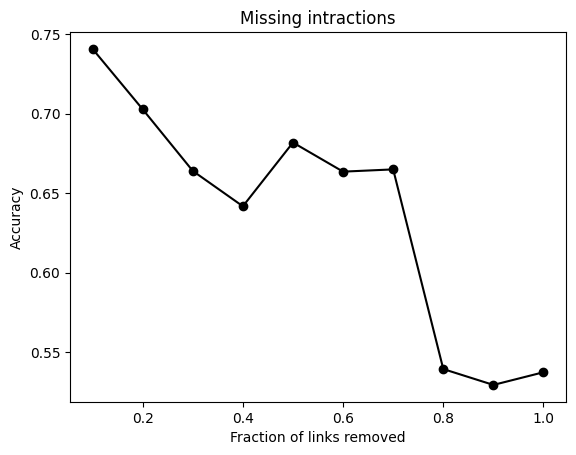

In [252]:
plt.plot(rat,accs,'-o',color='black')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links removed')
plt.title('Missing intractions')

Text(0.5, 1.0, 'Missing intractions')

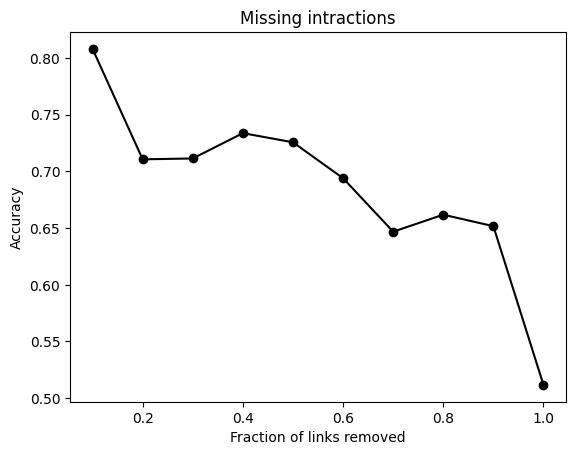

In [233]:
plt.plot(rat,accs,'-o',color='black')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links removed')
plt.title('Missing intractions')